defaultdict(<class 'list'>, {('Jake Sullivan', 'Hillary Clinton'): 815, ('nan', 'Hillary Clinton'): 20, ('Cheryl Mills', ';h'): 1, ('Cheryl Mills', 'Hillary Clinton'): 1182, ('Hillary Clinton', 'Huma Abedin'): 32, ('Hillary Clinton', 'russorv'): 26, ('slaughter anne-marie', 'Hillary Clinton'): 126, ('Harold Hongju Koh', 'Hillary Clinton'): 12, ('Wendy Sherman', 'Hillary Clinton'): 7, ('Jake Sullivan', 'Wendy Sherman'): 1, ('Hillary Clinton', 'sullivanjj'): 288, ('Sidney Blumenthal', 'Hillary Clinton'): 361, ('Burns Strider', 'Hillary Clinton'): 2, ('Huma Abedin', 'Hillary Clinton'): 1322, ('Cheryl Mills', 'Cheryl Mills'): 17, ('Robert Russo', 'Hillary Clinton'): 22, ('Capricia Marshall', 'Cheryl Mills'): 2, ('Hillary Clinton', 'Oscar Flores'): 5, ('William Burns', 'Hillary Clinton'): 10, ('Monica Hanley', 'Hillary Clinton'): 24, ('Hillary Clinton', 'abedinh'): 345, ('Hillary Clinton', 'millscd'): 298, ('Daniel Schwerin', 'Hillary Clinton'): 9, ('Hillary Clinton', 'hanleymr'): 33, ('Mon

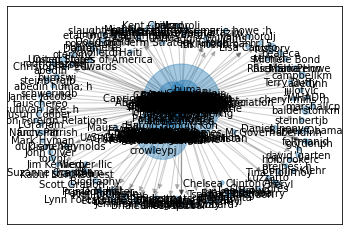

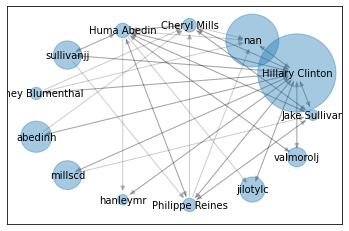

In [7]:
# 用PageRank挖掘希拉里邮件中的重要任务关系
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 数据加载
emails = pd.read_csv("./Emails.csv")
# 读取别名文件
file = pd.read_csv("./Aliases.csv")
aliases = {}
for index, row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']
# 读取人名文件
file = pd.read_csv("./Persons.csv")
persons = {}
for index, row in file.iterrows():
    persons[row['Id']] = row['Name']

# 针对别名进行转换        
def unify_name(name):
    # 姓名统一小写
    name = str(name).lower()
    # 去掉, 和@后面的内容
    name = name.replace(",","").split("@")[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name
# 画网络图
def show_graph(graph, type = 'spring_layout'):
    if type == 'spring_layout':
        # 使用Spring Layout布局，类似中心放射状
        positions=nx.spring_layout(graph)
    if type == 'circular_layout':
        # 使用Circular Layout布局，在一个圆环上均匀分布
        positions=nx.circular_layout(graph)

    # 设置网络图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*20000
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)]
    # 设置网络图中的边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4)
    # 绘制边
    #nx.draw_networkx_edges(graph, positions, edge_size=edgesize, alpha=0.2)
    nx.draw_networkx_edges(graph, positions, alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    # 输出希拉里邮件中的所有人物关系图
    plt.show()

# 将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

# 设置遍的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1

print(edges_weights_temp)
print('-'*100)
# 转化格式 (from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的PR值，并作为节点的pagerank属性
pagerank = nx.pagerank(graph)
# 获取每个节点的pagerank数值
pagerank_list = {node: rank for node, rank in pagerank.items()}
# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph, name = 'pagerank', values=pagerank_list)
# 画网络图
show_graph(graph)

# 将完整的图谱进行精简
# 设置PR值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉PR值小于pagerank_threshold的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold: 
        small_graph.remove_node(n)
# 画网络图
show_graph(small_graph, 'circular_layout')
